## 4 Pre-processing and Training<a id='4_Pre-processing_and_Training'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Loading the Data](#4.4_Loading_the_Data)
  * [4.5 Creating Dummy Features](#4.5_Creating_Dummy_Features)
  * [4.6 Train/Test Split](#4.6_Train/Test_Split)
  * [4.7 Feature Correlation](#4.7_Feature_Correlation)
  * [4.8 Scaling the Data](#4.8_Scaling_the_Data)
  * [4.9 Assess Performance](#4.9_Assess_Performance)
  * [4.10 Summary](#4.10_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

In this notebook we'll begin building machine learning models. Dummy features will be created and the numerical data will be standardized. I've included a a quick random forest model for this data. I printed various metrics to breifly assess this model's performance before going more in depth with other models.

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn import __version__ as sklearn_version
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir(r'C:\Users\daenj\OneDrive\Desktop\Datasets\Capstone 2021')
os.getcwd()

'C:\\Users\\daenj\\OneDrive\\Desktop\\Datasets\\Capstone 2021'

## 4.4 Loading the Data<a id='4.4_Loading_the_Data'></a>

In [3]:
data = pd.read_csv('cleaned_data.csv')
data = data.drop(columns='Unnamed: 0')
data_df = pd.DataFrame(data)

## 4.5 Creating Dummy Features<a id='4.5_Creating_Dummy_Features'></a>

Let's create dummy features for our data.

In [4]:
new_data = pd.get_dummies(data_df, columns = None, drop_first=True)

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

This Train/Test split has 30% of the data on the test split. As stated earlier, our target is either a 1 or 0 for all of the borrowers. 

In [5]:
X = new_data.drop('TARGET', axis=1) 
target = new_data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)

In [6]:
X_train.shape, X_test.shape

((215257, 122), (92254, 122))

In [7]:
y_train.shape, y_test.shape

((215257,), (92254,))

## 4.7 Feature Correlation<a id='4.7_Feature_Correlation'></a>

In [8]:
correlated_features = set()
correlation_matrix = new_data.corr()

In [9]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [10]:
#These are the features that will be dropped.
print(correlated_features)

{'FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'AMT_GOODS_PRICE', 'ORGANIZATION_TYPE_XNA', 'REGION_RATING_CLIENT_W_CITY'}


In [11]:
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

## 4.8 Scaling the Data<a id='4.8_Scaling_the_Data'></a>

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_defaults_median = X_train.median()
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

## 4.9 Assess Performance<a id='4.9_Assess_Performance'></a>

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Precision-Recall Curve With SVM Model <a id='Precision-Recall_Curve_With_SVM_Model'></a>

In [14]:
from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(X_tr_scaled, y_train)

LinearSVC()

I decided to use a linear support vector classifier because it works faster than the other classifiers. 

In [15]:
from sklearn.metrics import average_precision_score

y_score = classifier.decision_function(X_te_scaled)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.14


The average P-R score of 0.14 means that as the model creates predicitons, the recall score gets closer to one as precision stays above 0.10. A recall score of 1 means that the model correctly identifies all of the actual positives. A precision score of 1 means that the model correctly made positive identifications. What does the P-R curve look like?

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.14')

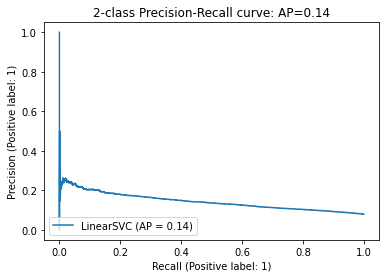

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier, X_te_scaled, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

As the SVM model keeps predicting, the precision goes down but the recall consistently increases. 

In [17]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score

model_res = classifier.fit(X_tr_scaled, y_train)

y_pred = model_res.predict(X_te_scaled)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Support Vector Machine (SVM): f1-score=%.3f' % (f1))

Support Vector Machine (SVM): f1-score=0.882


A perfect f1-score is a 1. In this case, the f1-score of 0.882 means that the model predicts low false positives and low false negatives.

## Confusion Matrix<a id='Confusion_Matrix'></a>

Confusion matrix, without normalization
[[84837    77]
 [ 7326    14]]
Normalized confusion matrix
[[9.99e-01 9.07e-04]
 [9.98e-01 1.91e-03]]


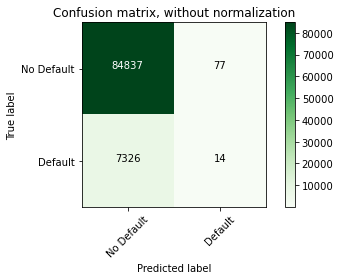

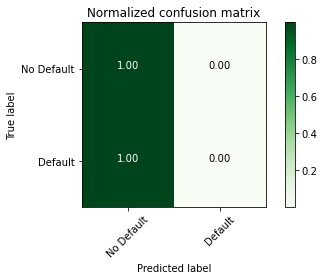

In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names=['No Default','Default'] 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

## Saving the Model<a id='Saving the Model'></a>

In [19]:
import pickle
filename = 'final_model.sav'
pickle.dump(model_res, open(filename, 'wb'))

## 4.10 Summary<a id='4.10_Summary'></a>

I chose to use a support vector machine with a linear support vector classifier for this classification problem. A train/test split was created before investigating feature correlations. Features that were highly correlated (above 95%) were removed from the dataset before building the logistic regression model. A confusion matrix and classification report were created to assess the results. There were a few false positives and thousands of false negatives.  